# Glacier grids from SGI or GLAMOS:

Creates monthly grid files for the MBM to make PMB predictions over the whole glacier grid. The files come from the SGI grid and use OGGM topography. Computing takes a long time because of the conversion to monthly format.
## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas as gpd
import geopandas as gpd

# scripts
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.geodata import *
from scripts.xgb_helpers import *
from scripts.config_CH import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.SwitzerlandConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()  # in case no memory

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

# Climate columns
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
# Topographical columns
voi_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
    "topo",
]


### Read PMB data:

Note that the SGI shapefiles use a slightly different RGI number than OGGM and this is why we use `rgi_id_v6_2016_shp`.

In [3]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr + 'csv/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

# Glacier outlines:
glacier_outline_sgi = gpd.read_file(
    "../../../data/GLAMOS/topo/SGI2020/SGI_2016_glaciers_copy.shp"
)  # Load the shapefile
glacier_outline_rgi = gpd.read_file(
    '../../../data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'
)

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(glacier_list, gl_area)
glacier_list

Number of glaciers with pcsr: 31


['schwarzbach',
 'taelliboden',
 'pizol',
 'sanktanna',
 'corvatsch',
 'sexrouge',
 'murtel',
 'plattalva',
 'tortin',
 'basodino',
 'limmern',
 'adler',
 'hohlaub',
 'albigna',
 'tsanfleuron',
 'silvretta',
 'oberaar',
 'gries',
 'clariden',
 'gietro',
 'schwarzberg',
 'forno',
 'plainemorte',
 'allalin',
 'otemma',
 'findelen',
 'rhone',
 'morteratsch',
 'corbassiere',
 'gorner',
 'aletsch']

# SGI (2015) grids:

## Examine SGI data:
### Glacier masks over SGI aspect:
This is to check that there is a good overlap.

In [ ]:
# Clear output folder
emptyfolder('figures/SGI_mask/')

for glacier_name in tqdm(glacier_list, desc="Processing glaciers"):

    # Handle 'clariden' separately due to special ID format
    sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)

    # Skip if no SGI ID
    if not sgi_id:
        print(f'No SGI ID found for {glacier_name}')
        continue

    # Get glacier mask from SGI shapefile
    gdf_mask_gl = glacier_outline_sgi[glacier_outline_sgi.RGIId == rgi_shp]

    # Skip if no glacier mask found
    if gdf_mask_gl.empty:
        print(f'No glacier mask found for {glacier_name}')
        continue

    # Locate aspect grid file
    aspect_gl = next(
        (f for f in os.listdir(os.path.join(path_SGI_topo, 'aspect'))
         if sgi_id in f), None)

    # Skip if no aspect file found
    if not aspect_gl:
        print(f'No aspect file found for {glacier_name}')
        continue

    # Load grid file
    metadata_aspect, grid_data_aspect = load_grid_file(
        os.path.join(os.path.join(path_SGI_topo, 'aspect'), aspect_gl))

    # Convert to xarray
    aspect = convert_to_xarray_geodata(grid_data_aspect, metadata_aspect)

    # Transform to WGS84 coordinates
    aspect_wgs84 = transform_xarray_coords_lv95_to_wgs84(aspect)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 10))
    aspect_wgs84.plot(ax=ax)
    gdf_mask_gl.plot(ax=ax, alpha=0.5)

    # Save the figure
    output_path = os.path.join('figures', 'SGI_mask', f"{glacier_name}.png")
    plt.savefig(output_path, dpi=300)
    plt.close()

### Compare one example grid of SGI to OGGM:

In [ ]:
# Glacier name
glacier_name = 'rhone'

# Get SGI ID and RGI shapefile ID safely
try:
    sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)
except KeyError:
    print(f"Error: {glacier_name} not found in rgi_df")
    sgi_id, rgi_id, rgi_shp = '', '', ''

if not sgi_id or not rgi_id or not rgi_shp:
    print(f"Warning: Missing data for {glacier_name}. Skipping...")
else:
    # Load SGI masked dataset
    ds = xr_SGI_masked_topo(rgi_shp, glacier_outline_sgi, sgi_id)
    if ds is None:
        print(
            f"Warning: Failed to load SGI dataset for {glacier_name}. Skipping..."
        )
    else:
        # Load OGGM dataset
        oggm_path = os.path.join(path_OGGM, 'xr_grids', f'{rgi_id}.nc')

        try:
            ds_oggm = xr.open_dataset(oggm_path)
        except FileNotFoundError:
            print(
                f"Error: OGGM dataset not found for {glacier_name}. Skipping..."
            )
            ds_oggm = None

        # Calculate SGI resolution
        dx_sgi, dy_sgi = get_res_from_degrees(ds)
        print(f"Cell size of SGI: {dx_sgi:.2f} x {dy_sgi:.2f} meters")

        if ds_oggm is not None:
            # Calculate OGGM resolution
            dx_oggm = abs(ds_oggm.x[1] - ds_oggm.x[0])
            dy_oggm = abs(ds_oggm.y[1] - ds_oggm.y[0])
            print(f"Cell size of OGGM: {dx_oggm:.2f} x {dy_oggm:.2f} meters")

            # Plot the data
            fig, axs = plt.subplots(2, 4, figsize=(15, 8))

            # SGI Data
            ds.masked_aspect.plot(ax=axs[0, 0],
                                  cmap='twilight_shifted',
                                  add_colorbar=False)
            ds.masked_slope.plot(ax=axs[0, 1],
                                 cmap='cividis',
                                 add_colorbar=False)
            ds.masked_elev.plot(ax=axs[0, 2],
                                cmap='terrain',
                                add_colorbar=False)
            ds.glacier_mask.plot(ax=axs[0, 3],
                                 cmap='binary',
                                 add_colorbar=False)

            axs[0, 0].set_title("Aspect SGI")
            axs[0, 1].set_title("Slope SGI")
            axs[0, 2].set_title("DEM SGI")
            axs[0, 3].set_title("Glacier mask SGI")

            # OGGM Data
            if all(var in ds_oggm
                   for var in ['aspect', 'slope', 'topo', 'glacier_mask']):
                ds_oggm.aspect.plot(ax=axs[1, 0],
                                    cmap='twilight_shifted',
                                    add_colorbar=False)
                ds_oggm.slope.plot(ax=axs[1, 1],
                                   cmap='cividis',
                                   add_colorbar=False)
                ds_oggm.topo.plot(ax=axs[1, 2],
                                  cmap='terrain',
                                  add_colorbar=False)
                ds_oggm.glacier_mask.plot(ax=axs[1, 3],
                                          cmap='binary',
                                          add_colorbar=False)

                axs[1, 0].set_title("Aspect OGGM")
                axs[1, 1].set_title("Slope OGGM")
                axs[1, 2].set_title("DEM OGGM")
                axs[1, 3].set_title("Glacier mask OGGM")
            else:
                print(
                    f"Warning: Some OGGM variables are missing in {oggm_path}")

            # Set axis labels
            for ax in axs.flatten():
                ax.set_xlabel("x")
                ax.set_ylabel("y")
                ax.legend().remove()

            # Optimize layout
            plt.tight_layout()
            plt.show()

In [ ]:
# Resample SGI grid:
# Coarson to 30 m resolution
ds_resampled = coarsenDS(ds)

# Calculate resolution
dx_m, dy_m = get_res_from_degrees(ds_resampled)
print(f"Cell size of resampled grid: {dx_m:.2f} x {dy_m:.2f} meters")

# Plot resampled grid
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_resampled.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_resampled.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds_resampled.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds_resampled.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

## Yearly masked grids - xarrays:
Save an .zarr file per glacier per year (not in monthly format) needed in the MBM later.

In [ ]:
# Define save path and ensure it exists
path_save = os.path.join(path_SGI_topo, 'xr_masked_grids/')
emptyfolder(path_save)

for glacier_name in tqdm(glacier_list, desc="Processing glaciers"):
    sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)

    # Skip glacier if required data is missing
    if not sgi_id or not rgi_shp:
        print(
            f"Warning: Missing SGI ID or shapefile for {glacier_name}. Skipping..."
        )
        continue

    # Load dataset
    try:
        ds = xr_SGI_masked_topo(rgi_shp, glacier_outline_sgi, sgi_id)
        if ds is None:
            print(
                f"Warning: Failed to load dataset for {glacier_name}. Skipping..."
            )
            continue
    except Exception as e:
        print(f"Error loading dataset for {glacier_name}: {e}")
        continue

    # Coarsen dataset to 30m resolution
    try:
        ds_resampled = coarsenDS(ds)
        if ds_resampled is None:
            print(
                f"Warning: Resampling failed for {glacier_name}. Skipping...")
            continue
    except Exception as e:
        print(f"Error during resampling for {glacier_name}: {e}")
        continue

    # Save dataset
    try:
        # save to zarr
        save_path = os.path.join(path_save, f"{glacier_name}.zarr")
        ds_resampled.to_zarr(save_path)

        print(f"Saved {glacier_name} dataset to {save_path}")
    except Exception as e:
        print(f"Error saving dataset for {glacier_name}: {e}")

In [ ]:
# Load the dataset
glacier_name = 'rhone'
path_save = os.path.join(path_SGI_topo, 'xr_masked_grids/')
path = os.path.join(path_save, f"{glacier_name}.zarr")
ds = xr.open_dataset(path)
ds

## Monthly masked grids - dataframes:

In [ ]:
def find_processed_and_incomplete_glaciers(folder_path, all_glaciers):
    """
    Identifies glaciers that are fully processed and those with missing years.

    Parameters:
        folder_path (str): Path to the folder containing the files.
        all_glaciers (list): List of all glaciers that need to be processed.

    Returns:
        tuple: A list of fully processed glaciers and a dictionary of incomplete glaciers with missing years.
    """
    processed_years = defaultdict(set)

    # Regular expression to match the filename format
    pattern = re.compile(
        r'^(?P<glacier>[a-zA-Z_]+)_grid_(?P<year>\d{4})\.parquet$')

    # Iterate over all files in the folder
    os.makedirs(folder_path, exist_ok=True)
    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            glacier = match.group('glacier')
            year = int(match.group('year'))
            if 2000 <= year <= 2023:
                processed_years[glacier].add(year)

    fully_processed = []
    incomplete_glaciers = {}

    # Check for completeness for each glacier
    for glacier in all_glaciers:
        all_years = set(range(2000, 2024))
        if glacier in processed_years:
            missing_years = all_years - processed_years[glacier]
            if not missing_years:
                fully_processed.append(glacier)
            else:
                incomplete_glaciers[glacier] = sorted(missing_years)
        else:
            incomplete_glaciers[glacier] = sorted(all_years)

    return fully_processed, incomplete_glaciers


# Uncomment if you want to clear previous files
# emptyfolder(path_glacier_grid_sgi)

fully_processed, incomplete_glaciers = find_processed_and_incomplete_glaciers(
    path_glacier_grid_sgi, glacier_list)

print(f"Fully processed glaciers: {len(fully_processed)}")
print(f"Incomplete glaciers: {len(incomplete_glaciers)}")

In [ ]:
RUN = False
if RUN:
    for glacier_name in tqdm(incomplete_glaciers.keys(),
                             desc='Processing glaciers'):
        print(
            f"\n-----------------------------------\nProcessing {glacier_name}"
        )
        sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)

        for year in tqdm(incomplete_glaciers[glacier_name],
                         desc='Years',
                         leave=False):
            print(f"  - Processing year: {year}")

            # Skip glacier if required data is missing
            if not sgi_id or not rgi_id or not rgi_shp:
                print(
                    f"Warning: Missing SGI ID or RGI shapefile for {glacier_name}. Skipping..."
                )
                continue

            # Load SGI masked grid (previously resampled)
            try:
                path_save = os.path.join(path_SGI_topo, 'xr_masked_grids/')
                path = os.path.join(path_save, f"{glacier_name}.zarr")
                ds_coarsened = xr.open_dataset(path)
            except Exception as e:
                print(f"Error loading dataset for {glacier_name}: {e}")
                continue

            # Create glacier grid
            try:
                df_grid = create_glacier_grid_SGI(glacier_name, year, rgi_id,
                                                  ds_coarsened)
                df_grid.reset_index(drop=True, inplace=True)
                dataset_grid = mbm.Dataset(cfg=cfg,
                                           data=df_grid,
                                           region_name='CH',
                                           data_path=path_PMB_GLAMOS_csv)
            except Exception as e:
                print(
                    f"Error creating glacier grid for {glacier_name} in {year}: {e}"
                )
                continue

            # Add climate data
            print('  - Adding climate data...')
            try:
                era5_climate_data = os.path.join(
                    path_ERA5_raw, 'era5_monthly_averaged_data.nc')
                geopotential_data = os.path.join(
                    path_ERA5_raw, 'era5_geopotential_pressure.nc')
                dataset_grid.get_climate_features(
                    climate_data=era5_climate_data,
                    geopotential_data=geopotential_data,
                    change_units=True)
            except Exception as e:
                print(
                    f"Error adding climate data for {glacier_name} in {year}: {e}"
                )
                continue

            # Add potential clear sky radiation
            print('  - Adding potential clear sky radiation...')
            try:
                dataset_grid.get_potential_rad(os.path.join(path_pcsr, 'csv/'))
            except Exception as e:
                print(
                    f"Error adding clear sky radiation for {glacier_name} in {year}: {e}"
                )
                continue

            # Add OGGM topographic data
            print('  - Adding OGGM data...')
            try:
                df_y_gl = dataset_grid.data
                df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

                # Add RGI IDs for OGGM data through intersection with shapefiles
                df_y_gl = mbm.data_processing.utils.get_rgi(
                    data=df_y_gl, glacier_outlines=glacier_outline_rgi)

                # Drop points without RGI ID (outside of RGI outlines)
                df_y_gl = df_y_gl.dropna(subset=['RGIId'])

                # Variables of interest
                voi = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]

                df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)
                dataset_grid = mbm.Dataset(cfg=cfg,
                                           data=df_y_gl,
                                           region_name='CH',
                                           data_path=path_PMB_GLAMOS_csv)
            except Exception as e:
                print(
                    f"Error adding OGGM data for {glacier_name} in {year}: {e}"
                )
                continue

            # Convert to monthly time resolution
            print('  - Converting to monthly time resolution...')
            try:
                dataset_grid.convert_to_monthly(
                    meta_data_columns=cfg.metaData,
                    vois_climate=vois_climate + ['pcsr'],
                    vois_topographical=voi_topographical)
                assert 'pcsr' in dataset_grid.data.columns, "Missing 'pcsr' column after conversion"
            except Exception as e:
                print(
                    f"Error converting to monthly resolution for {glacier_name} in {year}: {e}"
                )
                continue

            print(
                f"  - DF grid shape after conversion: {dataset_grid.data.shape}"
            )

            # Save gridded dataset
            # save_path = os.path.join(path_glacier_grid_sgi,
            #                          f"{glacier_name}_grid_{year}.csv")
            save_path = os.path.join(path_glacier_grid_sgi,
                                     f"{glacier_name}_grid_{year}.parquet")
            print(f"  - Saving dataset to {save_path}")
            try:
                # dataset_grid.data.to_csv(save_path, index=False)
                dataset_grid.data.to_parquet(save_path,
                                             engine="pyarrow",
                                             compression="snappy")
            except Exception as e:
                print(
                    f"Error saving dataset for {glacier_name} in {year}: {e}")

#### Examples:

In [ ]:
# Plot all OGGM variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
df = pd.read_parquet(path_glacier_grid_sgi + 'aletsch_grid_2000.parquet')
df = df[df.MONTHS == 'sep']
voi = ['hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v']
for i, var in enumerate(voi):
    sns.scatterplot(df,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=5,
                    alpha=0.5,
                    palette='twilight_shifted',
                    ax=axs[i])

# GLAMOS grids:

For the geodetic MB and gridded MB products computed by GLAMOS, they did not use the SGI grids (from 2015) but their own yearly DEMs. They're not available for all years, but we still compute monthly grids for these available glaciers and years, in order to make the comparison with geodetic MB fairer.

## Example of one glacier:

Cell size of GLAMOS DEM: 25.0 x 25.0 meters
Coarsened ds resolution: 49.895 x 50.058 meters


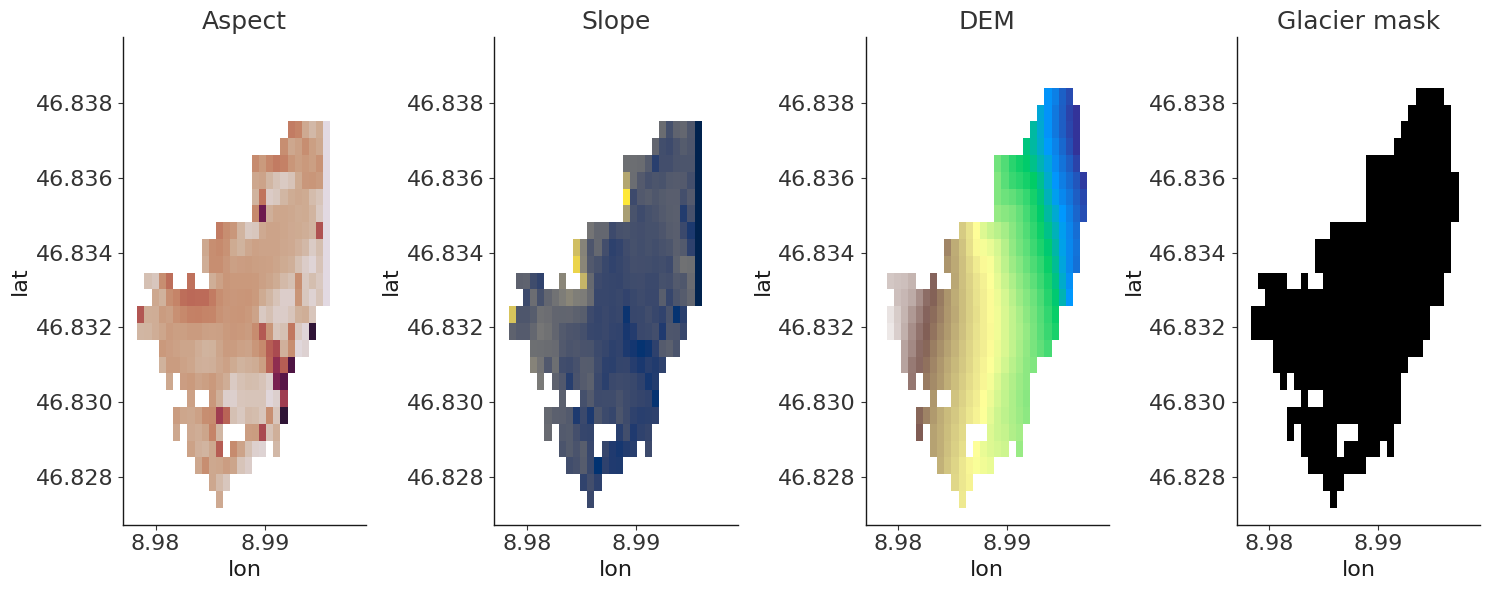

In [4]:
glacier_name = 'plattalva'
sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)

folder_path = path_GLAMOS_topo + glacier_name
pattern = re.compile(r'gl_(\d{4})_lv95\.grid')

# Extract years from filenames
years = set()
for filename in os.listdir(folder_path):
    match = pattern.match(filename)
    if match:
        years.add(int(match.group(1)))

# Sort and display the years
sorted_years = sorted(years)

# Example file
fileName = 'gl_1951_lv95.grid'
metadata, grid_data = load_grid_file(folder_path + '/' + fileName)

# Convert to xarray
dem_y = convert_to_xarray_geodata(grid_data, metadata)

# Transform the coordinates to WGS84
dem_wgs84_y = transform_xarray_coords_lv95_to_wgs84(dem_y)

# Create a mask where 'elevation' is not NaN (1 if not NaN, 0 if NaN)
ds_gl = xr.Dataset({'dem': dem_wgs84_y})
ds_gl["glacier_mask"] = ds_gl["dem"].notnull().astype(np.uint8)

dx = abs(ds_gl.x[1] - ds_gl.x[0]).values
dy = abs(ds_gl.y[1] - ds_gl.y[0]).values
print(f"Cell size of GLAMOS DEM: {dx} x {dy} meters")

# Extract SGI topo and aspect over GLAMOS DEM
ds = xr_GLAMOS_masked_topo(sgi_id, ds_gl)

# Coarson to 30 m resolution if needed
ds = coarsenDS(ds)
dx_m, dy_m = get_res_from_degrees(ds)
print(f"Coarsened ds resolution: {dx_m} x {dy_m} meters")

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted', add_colorbar=False)
ds.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

Cell size of GLAMOS DEM: 25.0 x 25.0 meters
Coarsened ds resolution: 49.882 x 50.06 meters


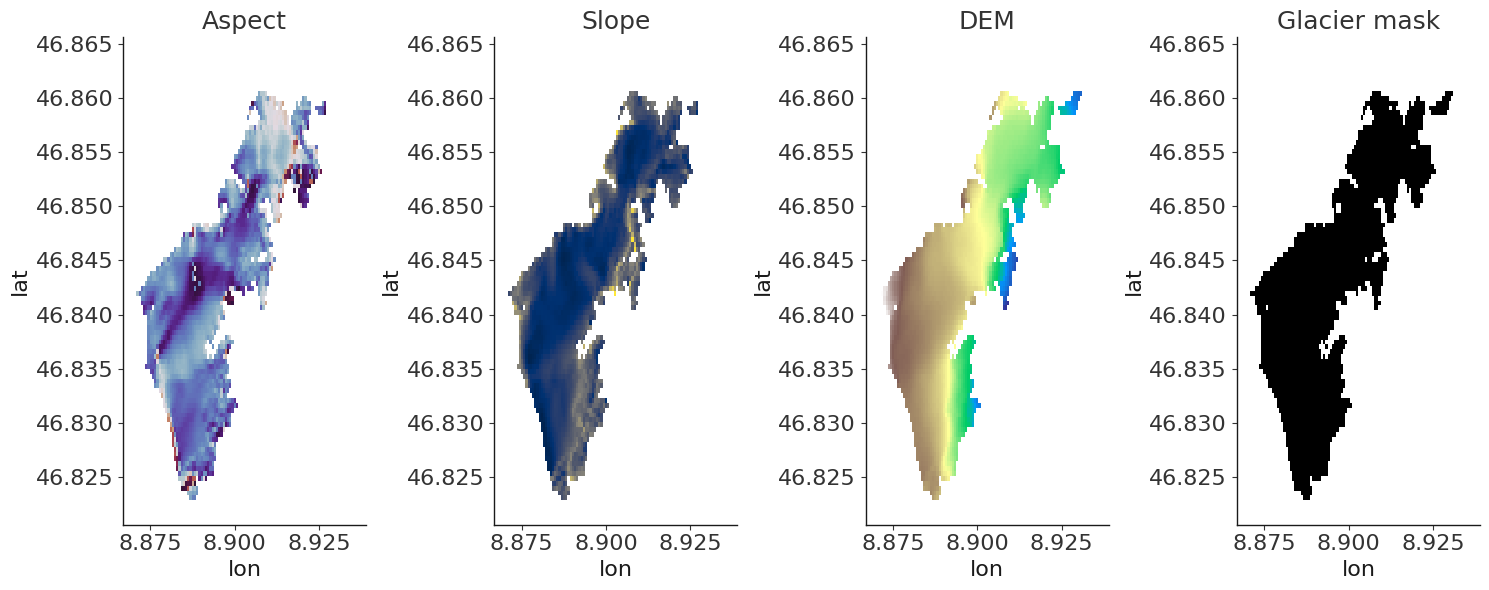

In [5]:
glacier_name = 'clariden'
sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)

folder_path = path_GLAMOS_topo + glacier_name
pattern = re.compile(r'gl_(\d{4})_lv95\.grid')

# Extract years from filenames
years = set()
for filename in os.listdir(folder_path):
    match = pattern.match(filename)
    if match:
        years.add(int(match.group(1)))

# Sort and display the years
sorted_years = sorted(years)

# Example file
fileName = 'gl_1951_lv95.grid'
metadata, grid_data = load_grid_file(folder_path + '/' + fileName)

# Convert to xarray
dem_y = convert_to_xarray_geodata(grid_data, metadata)

# Transform the coordinates to WGS84
dem_wgs84_y = transform_xarray_coords_lv95_to_wgs84(dem_y)

# Create a mask where 'elevation' is not NaN (1 if not NaN, 0 if NaN)
ds_gl = xr.Dataset({'dem': dem_wgs84_y})
ds_gl["glacier_mask"] = ds_gl["dem"].notnull().astype(np.uint8)

dx = abs(ds_gl.x[1] - ds_gl.x[0]).values
dy = abs(ds_gl.y[1] - ds_gl.y[0]).values
print(f"Cell size of GLAMOS DEM: {dx} x {dy} meters")

# Extract SGI topo and aspect over GLAMOS DEM
ds = xr_GLAMOS_masked_topo(sgi_id, ds_gl)

# Coarson to 30 m resolution if needed
ds = coarsenDS(ds)
dx_m, dy_m = get_res_from_degrees(ds)
print(f"Coarsened ds resolution: {dx_m} x {dy_m} meters")

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted', add_colorbar=False)
ds.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

## Yearly masked grids - xarrays:
Save an .nc file per glacier per year (not in monthly format) needed in the MBM later.

In [7]:
# Define save path and ensure it exists
path_xr_grids = os.path.join(
    "../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/")

RUN = False

if RUN:
    emptyfolder(path_xr_grids)
    for glacier_name in tqdm(glacier_list, desc="Processing glaciers"):
        print(f"\nProcessing {glacier_name}...")

        # Handle 'clariden' separately due to special ID format
        sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)

        # Skip glacier if required data is missing
        if not sgi_id or not rgi_shp:
            print(
                f"Warning: Missing SGI ID or shapefile for {glacier_name}. Skipping..."
            )
            continue

        # Define glacier folder path
        folder_path = os.path.join(
            path_GLAMOS_topo,
            'stanna' if glacier_name == 'sanktanna' else glacier_name)

        # Check if folder exists
        if not os.path.exists(folder_path):
            print(
                f"Warning: Folder does not exist: {folder_path}. Skipping...")
            continue

        # Regular expression to extract years from filenames
        pattern = re.compile(r'gl_(\d{4})_lv95\.grid')

        # Extract available years from filenames
        years = sorted({
            int(match.group(1))
            for filename in os.listdir(folder_path)
            if (match := pattern.match(filename))
        })

        if not years:
            print(
                f"Warning: No valid year files found in {folder_path}. Skipping..."
            )
            continue

        printed_resolution_normal = False  # Track whether resolution has been printed
        printed_resolution_res = False  # Track whether resolution has been printed

        for i, year in enumerate(years):
            if year < 1951:  # no ERA5 data available before 1951
                continue

            file_name = f'gl_{year}_lv95.grid'
            file_path = os.path.join(folder_path, file_name)

            try:
                # Load grid file
                metadata, grid_data = load_grid_file(file_path)

                # Convert to xarray
                dem_y = convert_to_xarray_geodata(grid_data, metadata)

                # Transform the coordinates to WGS84
                dem_wgs84_y = transform_xarray_coords_lv95_to_wgs84(dem_y)

                # Create a mask where 'elevation' is not NaN (1 if not NaN, 0 if NaN)
                ds_gl = xr.Dataset({'dem': dem_wgs84_y})
                ds_gl["glacier_mask"] = ds_gl["dem"].notnull().astype(np.uint8)

                # Apply GLAMOS masked topo function
                ds = xr_GLAMOS_masked_topo(sgi_id, ds_gl)
                

                # Print resolution only once for the first valid year
                if not printed_resolution_normal:
                    dx_m, dy_m = get_res_from_degrees(ds)
                    print(f"ds normal resolution: {dx_m} x {dy_m} meters")
                    printed_resolution_normal = True  # Ensure it doesn't print again
                
                # For small glaciers, save as is:
                if dx_m < 20:
                    # Save xarray dataset
                    save_path = os.path.join(path_xr_grids, f"{glacier_name}_{year}.zarr")
                    ds.to_zarr(save_path)
                    
                else:
                    # Coarsen to 50 m resolution
                    ds_resampled = coarsenDS(ds, target_res_m=50)

                    # Save xarray dataset
                    save_path = os.path.join(path_xr_grids, f"{glacier_name}_{year}.zarr")
                    ds_resampled.to_zarr(save_path)

                    # Print resolution of resampled data only once
                    if not printed_resolution_res:
                        dx_m, dy_m = get_res_from_degrees(ds_resampled)
                        print(f"ds_resampled resolution: {dx_m} x {dy_m} meters")
                        printed_resolution_res = True  # Ensure it doesn't print again

            except Exception as e:
                print(f"Error processing {glacier_name} in {year}: {e}")

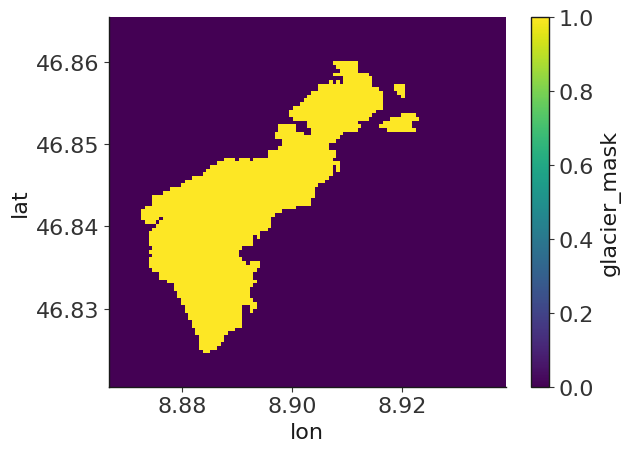

In [8]:
# open an example grid file
ds = xr.open_dataset(path_xr_grids + 'clariden_2018.zarr')
ds.glacier_mask.plot()

## Monthly masked grids - dataframes:

In [18]:
# Load RGI data
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',').rename(columns=lambda x: x.strip())

# Sort and set index for easier lookup
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

# Load geodetic mass balance data
geodeticMB = pd.read_csv(f"{path_geodetic_MB_glamos}dV_DOI2024_allcomb.csv")

# Extract relevant RGI IDs for glaciers in glacier_list
rgi_gl = data_glamos.loc[data_glamos.GLACIER.isin(glacier_list),
                         'RGIId'].unique()

# Map RGI IDs to SGI IDs
sgi_gl = rgi_df[rgi_df['rgi_id.v6'].isin(
    rgi_gl)]['sgi-id'].drop_duplicates().values

# Filter geodeticMB for relevant SGI IDs
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Create a mapping dictionary for glacier names
sgi_to_glacier_name = rgi_df[[
    'sgi-id'
]].reset_index().drop_duplicates().set_index('sgi-id')['short_name'].to_dict()

# Add glacier names based on SGI-ID mapping
geodeticMB['glacier_name'] = geodeticMB['SGI-ID'].map(sgi_to_glacier_name)

# Standardize naming convention
geodeticMB['glacier_name'].replace({'claridenU': 'clariden'}, inplace=True)

# filter to glacier_list
geodeticMB = geodeticMB[geodeticMB.glacier_name.isin(glacier_list)]

# Extract unique start and end years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacier_name')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacier_name')['A_end'].unique().apply(
    list).to_dict()

years_start_per_gl, years_end_per_gl

({'adler': [np.int64(2015)],
  'albigna': [np.int64(2015)],
  'aletsch': [np.int64(2008), np.int64(2009), np.int64(2017)],
  'allalin': [np.int64(2008), np.int64(2012), np.int64(2015), np.int64(2016)],
  'basodino': [np.int64(2008), np.int64(2012), np.int64(2014)],
  'clariden': [np.int64(2010), np.int64(2013), np.int64(2019)],
  'corbassiere': [np.int64(2008),
   np.int64(2010),
   np.int64(2016),
   np.int64(2017)],
  'corvatsch': [np.int64(2016)],
  'findelen': [np.int64(2007), np.int64(2015)],
  'forno': [np.int64(2015)],
  'gietro': [np.int64(2008),
   np.int64(2010),
   np.int64(2013),
   np.int64(2016),
   np.int64(2017)],
  'gorner': [np.int64(2015)],
  'gries': [np.int64(2007),
   np.int64(2011),
   np.int64(2013),
   np.int64(2014),
   np.int64(2015),
   np.int64(2016),
   np.int64(2017)],
  'hohlaub': [np.int64(2008), np.int64(2015), np.int64(2017)],
  'limmern': [np.int64(2010), np.int64(2013)],
  'morteratsch': [np.int64(2008), np.int64(2015)],
  'murtel': [np.int64(2015)]

In [19]:
path_xr_grids = os.path.join(
    "../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/")

RUN = True
if RUN:
    #emptyfolder(path_glacier_grid_glamos)
    #for glacier_name in tqdm(glacier_list, desc="Processing glaciers"):
    for glacier_name in ['clariden']:
        folder_path = os.path.join(path_glacier_grid_glamos, glacier_name)
        os.makedirs(folder_path, exist_ok=True)  # Ensure folder exists

        # Get existing processed years
        existing_files = [
            f for f in os.listdir(folder_path)
            if re.search(r'_grid_(\d{4})\.csv$', f)
        ]
        existing_years = {
            int(re.search(r'_grid_(\d{4})\.csv$', f).group(1))
            for f in existing_files
        }

        # Get the longest period dynamically for the current glacier
        if glacier_name in years_start_per_gl and glacier_name in years_end_per_gl:
            longest_period = (years_start_per_gl[glacier_name][0],
                              years_end_per_gl[glacier_name][-1])
        else:
            print(f"Skipping {glacier_name}: missing start/end years")
            continue

        # Get available .zarr files for this glacier
        nc_files = [f for f in os.listdir(path_xr_grids) if glacier_name in f]
        nc_files.sort()
        print(f"\nProcessing {glacier_name}: {len(nc_files)} files found")

        if not nc_files:
            print(
                f"Warning: No NetCDF files found for {glacier_name}. Skipping..."
            )
            continue

        # Identify missing years
        missing_years = []
        for fileName in nc_files:
            match = re.search(r'_(\d{4})\.zarr$', fileName)
            if match:
                year = int(match.group(1))
                if year >= 1951 and year not in existing_years:
                    missing_years.append((year, fileName))

        if not missing_years:
            print(f"All years processed for {glacier_name}. Skipping...")
            continue
        else:
            print(
                f"Missing years for {glacier_name}: {[y[0] for y in missing_years]}"
            )

        for year, fileName in tqdm(missing_years,
                                   desc="Processing missing years",
                                   leave=False):
            try:
                # Load GLAMOS masked grid
                file_path = os.path.join(path_xr_grids, fileName)
                ds = xr.open_dataset(file_path)
                
                dx_m, dy_m = get_res_from_degrees(ds)
                print(f"masked grid resolution: {dx_m} x {dy_m} meters")

                # Handle 'clariden' separately due to its unique ID format
                sgi_id, rgi_id, rgi_shp = get_rgi_sgi_ids(glacier_name)

                # Skip glacier if required data is missing
                if not sgi_id or not rgi_id or not rgi_shp:
                    print(
                        f"Warning: Missing SGI ID or RGI shapefile for {glacier_name}. Skipping..."
                    )
                    continue

                # Create glacier grid
                df_grid = create_glacier_grid_SGI(glacier_name, year, rgi_id,
                                                  ds)
                df_grid.reset_index(drop=True, inplace=True)
                dataset_grid = mbm.Dataset(cfg=cfg,
                                           data=df_grid,
                                           region_name='CH',
                                           data_path=path_PMB_GLAMOS_csv)

                # Add climate data
                dataset_grid.get_climate_features(
                    climate_data=os.path.join(path_ERA5_raw,
                                              'era5_monthly_averaged_data.nc'),
                    geopotential_data=os.path.join(
                        path_ERA5_raw, 'era5_geopotential_pressure.nc'),
                    change_units=True)

                # Add potential clear sky radiation
                dataset_grid.get_potential_rad(os.path.join(path_pcsr, 'csv/'))

                # Process OGGM data
                df_y_gl = dataset_grid.data
                df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

                # Add RGI IDs through intersection with shapefiles
                df_y_gl = mbm.data_processing.utils.get_rgi(
                    data=df_y_gl, glacier_outlines=glacier_outline_rgi)

                # Drop points without RGI ID
                df_y_gl = df_y_gl.dropna(subset=['RGIId'])

                # Add OGGM features
                voi = ["hugonnet_dhdt", "consensus_ice_thickness", "millan_v"]
                df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)

                dataset_grid_oggm = mbm.Dataset(cfg=cfg,
                                                data=df_y_gl,
                                                region_name='CH',
                                                data_path=path_PMB_GLAMOS_csv)

                # Convert to monthly time resolution
                dataset_grid_oggm.convert_to_monthly(
                    meta_data_columns=cfg.metaData,
                    vois_climate=vois_climate + ['pcsr'],
                    vois_topographical=voi_topographical)

                assert 'pcsr' in dataset_grid_oggm.data.columns, "Missing 'pcsr' column after conversion"

                # Save gridded dataset
                save_path = os.path.join(
                    folder_path, f"{glacier_name}_grid_{year}.parquet")
                dataset_grid_oggm.data.to_parquet(save_path,
                                                  engine="pyarrow",
                                                  compression="snappy")
                print(f"Saved: {save_path}")

            except Exception as e:
                print(f"Error processing {glacier_name} ({year}): {e}")


Processing clariden: 74 files found
Missing years for clariden: [1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


Processing missing years:   0%|          | 0/74 [00:00<?, ?it/s]

masked grid resolution: 49.882 x 50.06 meters
Saved: ../../../data/GLAMOS/topo/gridded_topo_inputs/GLAMOS_grid/clariden/clariden_grid_1951.parquet
masked grid resolution: 49.882 x 50.06 meters
Saved: ../../../data/GLAMOS/topo/gridded_topo_inputs/GLAMOS_grid/clariden/clariden_grid_1952.parquet
masked grid resolution: 49.882 x 50.06 meters


##### Example:

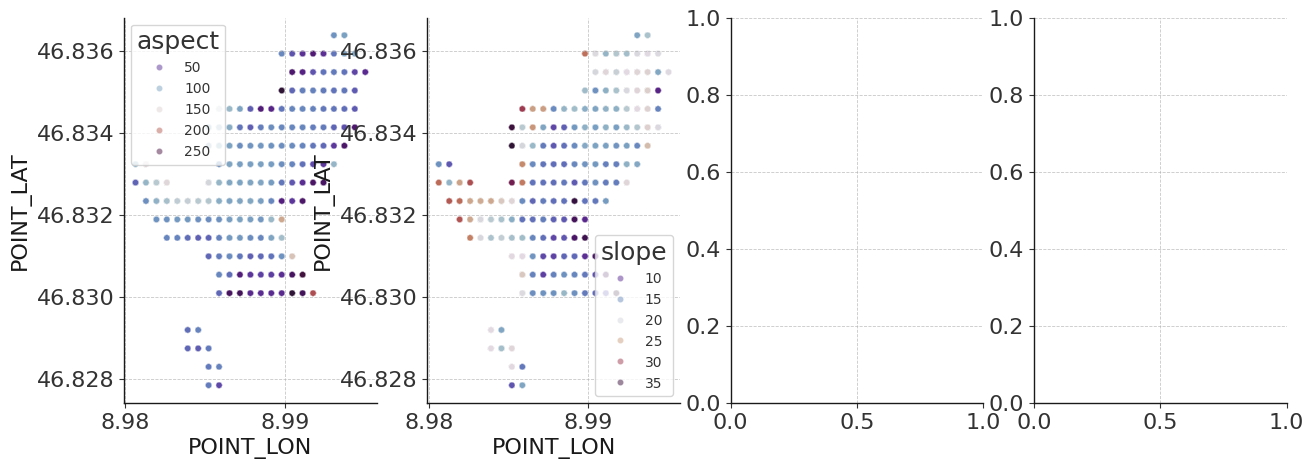

In [9]:
# Load GLAMOS masked grid
fileName = 'plattalva_1955.nc'
glacier_name = 'plattalva'
year = 1955

folder_path = os.path.join(path_glacier_grid_glamos, glacier_name)
# load the dataset
df = pd.read_parquet(
    os.path.join(folder_path, f"{glacier_name}_grid_{year}.parquet"))

# Variables of interest
voi = [
    "aspect",
    "slope",
]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, var in enumerate(voi):
    sns.scatterplot(df,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=20,
                    alpha=0.5,
                    palette='twilight_shifted',
                    ax=axs[i])